# Bike Sharing Demand
##### 문제 출처 : https://www.kaggle.com/c/bike-sharing-demand

#### 자전거 공유 시스템은 회원 가입, 임대 및 자전거 반환 절차가 도시 전역의 키오스크 위치 네트워크를 통해 자동화 된 자전거 대여 수단이다. 
#### 이 시스템을 사용하면 사람들은 한 곳에서 자전거를 빌려 필요할 때 다른 곳으로 돌려 보낼 수 있다. 
#### 현재 전세계에는 500 개가 넘는 자전거 공유 프로그램이 있다. 
#### 이러한 시스템에 의해 생성 된 데이터는 여행 기간, 출발 위치, 도착 위치 및 경과 시간이 명시 적으로 기록되므로 연구원에게 좋은 소재다. 
#### 따라서 자전거 공유 시스템은 도시의 이동성을 연구하는 데 사용할 수있는 센서 네트워크의 기능을 수행한다. 
#### 이번 실습은 워싱턴 DC의 Capital Bikeshare에서 제공한 과거 사용 패턴과 날씨 데이터에 추가적으로 데이터를 결합하고 다듬어 의미 있는 데이터를 추출할 것이다.

### 다음은 kaggle에서 제공하는 데이터들이다.
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

#### 나는 이 외에 NYC, Washington, D.C의 기름값, 일몰, 일출 시간을 추가하여 분석 정확도를 높였다. 이제 대한 자세한 내용은 아래에서 설명하겠다.

# Bike_Hyper parameter tunning

In [1]:
import random
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])

In [2]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Preprocessing
#### 먼저 전처리를 한다.

### Make year_month
#### train, test에 year 컬럼과 month 컬럼을 합친 새로운 컬럼을 추가한다.

In [3]:
train["datetime_year"] = train["datetime"].dt.year
train["datetime_month"] = train["datetime"].dt.month
train["datetime_day"] = train["datetime"].dt.day
train["datetime_hour"] = train["datetime"].dt.hour
train["datetime_minute"] = train["datetime"].dt.minute
train["datetime_second"] = train["datetime"].dt.second
train["datetime_dayofweek"] = train["datetime"].dt.dayofweek

In [4]:
test["datetime_year"] = test["datetime"].dt.year
test["datetime_month"] = test["datetime"].dt.month
test["datetime_day"] = test["datetime"].dt.day
test["datetime_hour"] = test["datetime"].dt.hour
test["datetime_minute"] = test["datetime"].dt.minute
test["datetime_second"] = test["datetime"].dt.second
test["datetime_dayofweek"] = test["datetime"].dt.dayofweek

In [5]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

In [6]:
train["datetime_year_month"] = train["datetime"].apply(concatenate_year_month)
test["datetime_year_month"] = test["datetime"].apply(concatenate_year_month)

### Make year_month_total
#### 위에서 합친 year_month를 년도 끼리도 이어 붙인다.

In [7]:
train_temp1 = train[train["datetime_year"] == 2011]["datetime_month"]
train_temp2 = train[train["datetime_year"] == 2012]["datetime_month"] + 12
train["datetime_year_month_total"] = pd.concat([train_temp1, train_temp2], axis=0)

test_temp1 = test[test["datetime_year"] == 2011]["datetime_month"]
test_temp2 = test[test["datetime_year"] == 2012]["datetime_month"] + 12
test["datetime_year_month_total"] = pd.concat([test_temp1, test_temp2], axis=0)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_minute,datetime_second,datetime_dayofweek,datetime_year_month,datetime_year_month_total
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,2011-1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,2011-1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,2011-1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,2011-1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,2011-1,1


### Make new_season
#### 기존 데이터에는 1-3월이 spring(1), 4-6월이 summer(2), 7-9월이 fall(3), 10-12월이 winter(4)로 되어 있다. 그런데 이렇게 하면 한겨울인 1월도 spring으로 처리되므로, 나는 3-5월을 봄으로 매핑하는 새로운 컬럼 new_season을 만들었다.

In [8]:
# 1 = spring, 2 = summer, 3 = fall, 4 = winter

train.loc[(3 <= train.datetime_month) & (5 >= train.datetime_month), "new_season"] = 1
test.loc[(3 <= test.datetime_month) & (5 >= test.datetime_month), "new_season"] = 1

train.loc[(6 <= train.datetime_month) & (8 >= train.datetime_month), "new_season"] = 2
test.loc[(6 <= test.datetime_month) & (8 >= test.datetime_month), "new_season"] = 2

train.loc[(9 <= train.datetime_month) & (11 >= train.datetime_month), "new_season"] = 3
test.loc[(9 <= test.datetime_month) & (11 >= test.datetime_month), "new_season"] = 3

train.loc[(12 == train.datetime_month) | (2 >= train.datetime_month), "new_season"] = 4
test.loc[(12 == test.datetime_month) | (2 >= test.datetime_month), "new_season"] = 4

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_minute,datetime_second,datetime_dayofweek,datetime_year_month,datetime_year_month_total,new_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,2011-1,1,4.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,2011-1,1,4.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,2011-1,1,4.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,2011-1,1,4.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,2011-1,1,4.0


### Make Discomfort_index
#### 불쾌 지수 컬럼을 만들어 discomfort_index라고 저장하였다.

In [9]:
train["discomfort_index"] = train.loc[:, "temp"] - 0.55*(1- 0.01*train.loc[:, "humidity"])*(train.loc[:, "temp"] - 14.5)
test["discomfort_index"] = test.loc[:, "temp"] - 0.55*(1- 0.01*test.loc[:, "humidity"])*(test.loc[:, "temp"] - 14.5)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_year,datetime_month,datetime_day,datetime_hour,datetime_minute,datetime_second,datetime_dayofweek,datetime_year_month,datetime_year_month_total,new_season,discomfort_index
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,2011-1,1,4.0,10.32697
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,2011-1,1,4.0,9.62280
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,2011-1,1,4.0,9.62280
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,2011-1,1,4.0,10.48075
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,2011-1,1,4.0,10.48075


### Monthly average gas prices of NYC, Washington, D.C
#### 자전거 대여 수요와 기름값의 상관 관계가 있을 것으로 예상하고 NYC, Washington, D.C의 2011~2012 기름값 데이터를 조사하여 별도의 csv 파일로 저장한 후 분석에 사용한다.
#### 처음에는 월 별 기름값을 분석에 사용하였는데, 추후에 주 별 기름값을 사용하게 되어, 이 셀은 지금은 사용하지 않는다.

In [10]:
# press = 300

# gas_prices = [334.9, 344.5, 375.7, 397.0, 416.2, 393.7, 391.9, 393.3, 387.1, 370.5, 364.7, 353.8]    # Monthly average gas prices of NYC (2011)
# for i, j in zip(range(1, 13), gas_prices):
#     train.loc[(train.datetime_year == 2011) & (train.datetime_month == i), "gas"] = j - press
# for i, j in zip(range(1, 13), gas_prices):
#     test.loc[(test.datetime_year == 2011) & (test.datetime_month == i), "gas"] = j - press
    
# gas_prices = [364.0, 386.0, 399.0, 409.3, 392.2, 368.8, 369.9, 393.2, 405.8, 399.2, 386.5, 375.6]    # Monthly average gas prices of NYC (2012)
# for i, j in zip(range(1, 13), gas_prices):
#     train.loc[(train.datetime_year == 2012) & (train.datetime_month == i), "gas"] = j - press
# for i, j in zip(range(1, 13), gas_prices):
#     test.loc[(test.datetime_year == 2012) & (test.datetime_month == i), "gas"] = j - press

# train.head()

### Weekly average Gas prices of NYC, Washington, D.C
#### NYC, Washington, D.C의 주 별 평균 기름값 컬럼을 추가한다.

In [11]:
press = 200
gas_prices = pd.read_csv("data/weekly_gas_prices.csv", parse_dates=["datetime"])

data = pd.concat((train, test), axis=0).sort_values(by=["datetime"])  # row lengh: 17379
data.to_csv("data/data.csv", index=False)
data = pd.read_csv("data/data.csv", parse_dates=["datetime"])

for i, e in enumerate(np.array(gas_prices.loc[:,"price"])):
    if i*167+167 > len(data):
        data.ix[i*167 : len(data), "gas"] = e - press
    else:
        data.ix[i*167 : i*167+167, "gas"] = e - press
        
train = data.loc[(0 < data.datetime_day) & (19 >= data.datetime_day), :]
test = data.loc[19 < data.datetime_day, :]

train.head()

,atemp,casual,count,datetime,datetime_day,datetime_dayofweek,datetime_hour,datetime_minute,datetime_month,datetime_second,datetime_year,datetime_year_month,datetime_year_month_total,discomfort_index,holiday,humidity,new_season,registered,season,temp,weather,windspeed,workingday,gas
0,14.395,3.0,16.0,2011-01-01 00:00:00,1,5,0,0,1,0,2011,2011-1,1,10.32697,0,81,4.0,13.0,1,9.84,1,0.0,0,115.8
1,13.635,8.0,40.0,2011-01-01 01:00:00,1,5,1,0,1,0,2011,2011-1,1,9.62280,0,80,4.0,32.0,1,9.02,1,0.0,0,115.8
2,13.635,5.0,32.0,2011-01-01 02:00:00,1,5,2,0,1,0,2011,2011-1,1,9.62280,0,80,4.0,27.0,1,9.02,1,0.0,0,115.8
3,14.395,3.0,13.0,2011-01-01 03:00:00,1,5,3,0,1,0,2011,2011-1,1,10.48075,0,75,4.0,10.0,1,9.84,1,0.0,0,115.8
4,14.395,0.0,1.0,2011-01-01 04:00:00,1,5,4,0,1,0,2011,2011-1,1,10.48075,0,75,4.0,1.0,1,9.84,1,0.0,0,115.8


### Correlation between bike demand count and GAS prices of NYC, Washington, D.C
#### 하위의 그래프 두 개를 보자. 위의 그래프는 자전거 대여 수를 그린 것이고, 아래의 그래프는 NYC, Washington, D.C의 주 별 평균 기름값을 그린 것이다. 예상한대로 이 둘은 상관관계가 있을 뿐만 아니라, 기름값이 오히려 대여 수를 선행하고 있다.

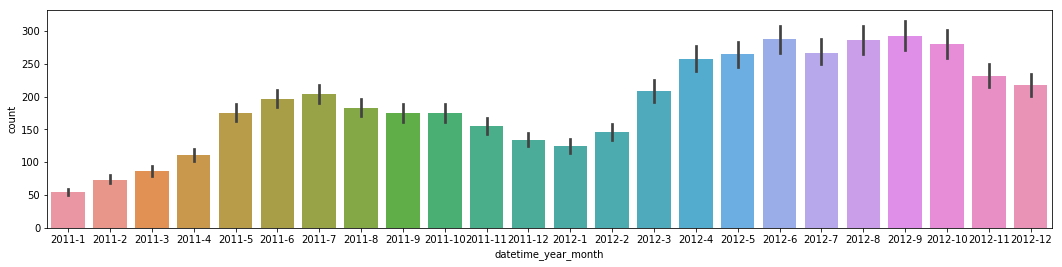

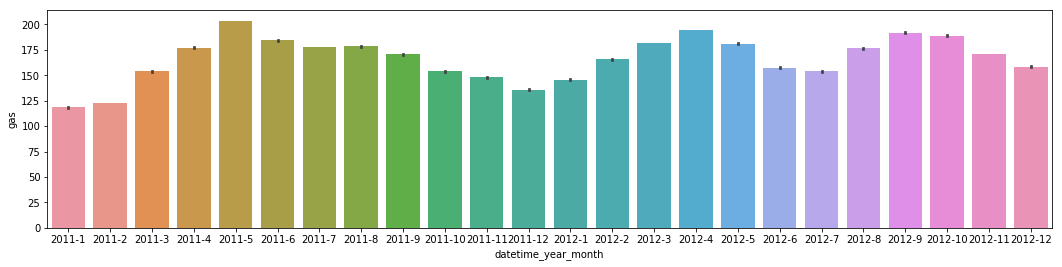

In [12]:
figure, (ax1) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.barplot(data=train, x="datetime_year_month", y="count", ax=ax1)


figure, (ax2) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)
sns.barplot(data=data, x="datetime_year_month", y="gas", ax=ax2)

### Preprocessing of sun_rise, sun_set
#### 해가 떠 있는 시간에는 대여 수요가 증가할 것이라 예상하여, NYC, Washington, D.C의 일몰, 일출 시간 데이터를 사용하였다. 이 셀은 텍스트 파일에 있는 일몰, 일출 시간 데이터를 전처리 하여 저장하는 과정이다.
#### 다만 이 텍스트 파일 데이터는 추후에 다른 파일로 대체 되어 지금은 이 셀을 사용하지 않는다.

In [13]:
# # 2011 sun rise set data
# file = open("data/rise_set_2011.txt", 'r')
# lines = file.readlines()

# count = 1
# for i, line in enumerate(lines):
#     lines[i] = line[count*2:]

# # sun set split
# count = 9
# for i, line in enumerate(lines):
#     print(line[(count*11)+2:(count*11)+4])

# # sun set split
# count = 9
# for i, line in enumerate(lines):
#     print(line[(count*11)+7:(count*11)+9])

# # 2012 sun rise set data
# file = open("data/rise_set_2012.txt", 'r')
# lines = file.readlines()

# count = 1
# for i, line in enumerate(lines):
#     lines[i] = line[count*2:]

# # sun set split
# count = 0
# for i, line in enumerate(lines):
#     print(line[(count*11)+2:(count*11)+4])

# # sun set split
# count = 0
# for i, line in enumerate(lines):
#     print(line[(count*11)+7:(count*11)+9])

### Make sun_rise, sun_set
#### 해가 떠 있는 시간에는 1, 해가 져 있는 시간에는 0인 sun 컬럼을 추가하였다.

In [14]:
rise_set = pd.read_csv("data/rise_set.csv")
calender = ["Jan_rise", "Jan_set", "Feb_rise", "Feb_set", "Mar_rise", "Mar_set", "Apr_rise", "Apr_set", "May_rise", "May_set", "June_rise", "June_set", 
"July_rise", "July_set", "Aug_rise", "Aug_set", "Sept_rise", "Sept_set", "Oct_rise", "Oct_set", "Nov_rise", "Nov_set", "Dec_rise", "Dec_set"]

In [15]:
for i in range(12):
    s_rise = rise_set.ix[:, calender[i*2]]
    for j in range(1,32):
        data.loc[(data.datetime_month == i+1) & (data.datetime_day == j) & (data.datetime_hour < s_rise.iloc[j-1]), "sun"] = 0    # sun off
        data.loc[(data.datetime_month == i+1) & (data.datetime_day == j) & (data.datetime_hour >= s_rise.iloc[j-1]), "sun"] = 1   # sun on
    s_set = rise_set.ix[:, calender[i*2 + 1]]
    for j in range(1,32):
        data.loc[(data.datetime_month == i+1) & (data.datetime_day == j) & (data.datetime_hour >= s_set.iloc[j-1]), "sun"] = 0   # sun off

train = data.loc[(0 < data.datetime_day) & (19 >= data.datetime_day), :]
test = data.loc[19 < data.datetime_day, :]

# train.loc[train.loc[:,"sun"].isnull(), :]
# test.loc[test.loc[:,"sun"].isnull(), :]

## Features select
#### 학습에 사용할 특성을 선택한다.

In [16]:
feature_names=["season", "holiday", "workingday", "temp", "atemp", "humidity", "windspeed", "datetime_year", "datetime_month", 
               "datetime_hour", "datetime_dayofweek", "weather", "gas", "sun"]
train[feature_names]

,season,holiday,workingday,temp,atemp,humidity,windspeed,datetime_year,datetime_month,datetime_hour,datetime_dayofweek,weather,gas,sun
0,1,0,0,9.84,14.395,81,0.0000,2011,1,0,5,1,115.8,0.0
1,1,0,0,9.02,13.635,80,0.0000,2011,1,1,5,1,115.8,0.0
2,1,0,0,9.02,13.635,80,0.0000,2011,1,2,5,1,115.8,0.0
3,1,0,0,9.84,14.395,75,0.0000,2011,1,3,5,1,115.8,0.0
4,1,0,0,9.84,14.395,75,0.0000,2011,1,4,5,1,115.8,0.0
5,1,0,0,9.84,12.880,75,6.0032,2011,1,5,5,2,115.8,0.0
6,1,0,0,9.02,13.635,80,0.0000,2011,1,6,5,1,115.8,0.0
7,1,0,0,8.20,12.880,86,0.0000,2011,1,7,5,1,115.8,1.0
8,1,0,0,9.84,14.395,75,0.0000,2011,1,8,5,1,115.8,1.0
9,1,0,0,13.12,17.425,76,0.0000,2011,1,9,5,1,115.8,1.0


In [17]:
x_train = train[feature_names]
x_test = test[feature_names]

label = "count"
y_train = train[label]

## Predict XGB and submission

### Make RMSLE Func
#### 교차 검증에 사용할 socre 함수를 정의한다. kaggle에서는 rmsle를 통해 평가하므로 이를 사용한다.

In [18]:
from sklearn.metrics import make_scorer
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)
    
    difference = log_predict - log_actual
    square_difference = difference ** 2
    mean_square_difference = square_difference.mean()
    
    score = np.sqrt(mean_square_difference)
    
    return score
rmsle_score = make_scorer(rmsle)

### XGB
#### XGB를 사용해 교차 검증 후, 점수를 출력한다.

In [21]:
n_estimators = 1000
max_depth = 40
xgb_cv = XGBRegressor(n_estimators = n_estimators,
                        max_depth = max_depth)
score = cross_val_score(xgb_cv, x_train, y_train, cv=10, scoring=rmsle_score).max()
print("Max score={0:.5f}, n_estimators={1}, max_depth={2}".format(score, n_estimators, max_depth))

[23:54:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:17] WARNI

### Submission

In [ ]:
# Fit and prediction
xgb_cv.fit(x_train, y_train)
prediction = xgb_cv.predict(x_test)

submission = pd.read_csv("data/sampleSubmission.csv")
submission["count"] = prediction

# File created
submission.to_csv("submission/bike_xgb.csv", index=False)